## Intro
This code shows an example of using OWAD upon abnormal-confidence anomaly detection models (e.g., RMSE of Auto-Encoder). Here we use a NIDS case with `Auto-Encoder` as the anomaly detection model and `Kyoto-2006` as the traffic dataset.

(**First, you need to unzip `demo/data/2007.npz.gz` and `demo/data/2011.npz.gz`**)

In [1]:
%load_ext autoreload
%autoreload 2
## import packages
import sys
sys.path.append('../admodels/')
sys.path.append('../moudles/')
sys.path.append('../baselines/')
sys.path.append('../')
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import _pickle as pkl
import AE
from calibrator import Calibrator
from shifthunter import ShiftHunter
import myutils as utils

../myutils.py:14: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
../myutils.py:14: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


## Prepare AD model and data

In [2]:
## Train an initial anomlay detection model (Auto-Encoder)
utils.set_random_seed()
feat = np.load('./data/2007.npz')
train_num = 50000
X, y = feat['X'], feat['y']
X_ben = X[y==0]
X_train = X_ben[:train_num]
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
model, thres = AE.train(X_train, X_train.shape[-1])

epoch:0/10 |Loss: 0.013858606107532978
epoch:1/10 |Loss: 0.0133657893165946
epoch:2/10 |Loss: 0.0129871079698205
epoch:3/10 |Loss: 0.012550868093967438
epoch:4/10 |Loss: 0.01211856584995985
epoch:5/10 |Loss: 0.011814645491540432
epoch:6/10 |Loss: 0.011295180767774582
epoch:7/10 |Loss: 0.010719403624534607
epoch:8/10 |Loss: 0.009908968582749367
epoch:9/10 |Loss: 0.008849688805639744
max AD score 0.14363609
thres: 0.111118615


Original Performance @2007
roc_auc: 0.9472406146666666


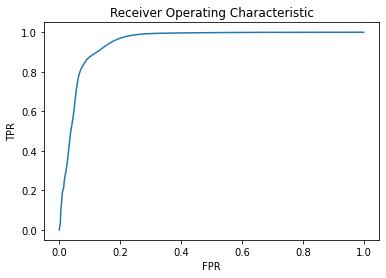

Before Adaptation @2011:
roc_auc: 0.80741201806346


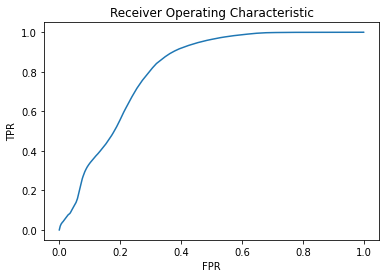

In [3]:
## Load Control (2007) and Treatment (2011) Dataset
%matplotlib inline
FEAT_0 = np.load('./data/2007.npz')
X_0, y_0 = scaler.transform(FEAT_0['X']), FEAT_0['y']

FEAT_1 = np.load('./data/2011.npz')
X_1, y_1 = scaler.transform(FEAT_1['X']), FEAT_1['y']

## Test Original Performance @2007 and @2011
print('Original Performance @2007')
y_pred_0, y_prob_0 = AE.test(model, thres, X_0)
utils.multi_metrics(y_prob_0, y_0, thres*1.5)

print('Before Adaptation @2011:')
y_pred_1, y_prob_1 = AE.test(model, thres, X_1)
utils.multi_metrics(y_prob_1, y_1, thres*1.5)

## Clip validation set for Control and Treatment data
rmse_c = y_prob_0[:train_num]
rmse_t = y_prob_1[:train_num]
X_con = X_0[:train_num]
X_tre = X_1[:train_num]

**(As we can see that, the performance decreases from 2007 to 2011, i.e, from 0.94 to 0.80)**

## Enjoy OWAD

NOTICE: Initialize OWAD Calibrator Under **Isotonic** Method!
NOTICE: uncalibrated Probs is **MALICIOUS** confidence
NOTICE: Initilize OWAD Shift Handler Under **Tab** Mode!


../myutils.py:14: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


Shift! P-value is 0.000999000999000999
Visualize Shift:


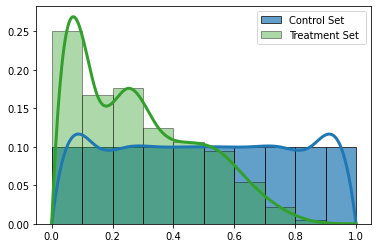

In [4]:
## Detect whether shift happens between 2007 and 2011
utils.set_random_seed()
cb = Calibrator(X_con, method='Isotonic')
cb.set_calibrator(rmse_c, is_P_mal=True)
sh = ShiftHunter(rmse_c, rmse_t, cb, ad_type='Tab')
t = utils.get_params('ShiftDetector')['test_thres']
p_value = sh.permu_test()
if p_value >= t:
    print("Non-shift, skip explain and adaptation!")
else:
    print('Shift! P-value is', p_value)
print("Visualize Shift:")
sh.visualize_hists()

**(As we can see that, OWAD detects shift with full confidence. We can also confirm the shift from the above visualization of calibrated output distribution)**

step:0 |Loss:16.0000 |Accuracy_Loss:1.0000 |Overhead_Loss:1.0000 |Determinism_Loss:1.0000 |M_c num: 25120 |M_t num: 25575
step:10 |Loss:14.7412 |Accuracy_Loss:0.7895 |Overhead_Loss:0.9772 |Determinism_Loss:1.0212 |M_c num: 24692 |M_t num: 24904
step:20 |Loss:13.7678 |Accuracy_Loss:0.6341 |Overhead_Loss:0.9571 |Determinism_Loss:1.0264 |M_c num: 24243 |M_t num: 23946
step:30 |Loss:12.9307 |Accuracy_Loss:0.5040 |Overhead_Loss:0.9390 |Determinism_Loss:1.0206 |M_c num: 23858 |M_t num: 22804
step:40 |Loss:12.2222 |Accuracy_Loss:0.3993 |Overhead_Loss:0.9218 |Determinism_Loss:1.0076 |M_c num: 23602 |M_t num: 21481
step:49 |Loss:11.6429 |Accuracy_Loss:0.3186 |Overhead_Loss:0.9058 |Determinism_Loss:0.9914 |M_c num: 23434 |M_t num: 20131
** Cliping <remain_X_t> ...
Remain X_c.shape (26586, 497) X_t.shape (10000, 497)
Adapter: Begin Processing ... 
 Estimating Params Weight:0/12000
 Estimating Params Weight:2000/12000
 Estimating Params Weight:4000/12000
 Estimating Params Weight:6000/12000
 Estim

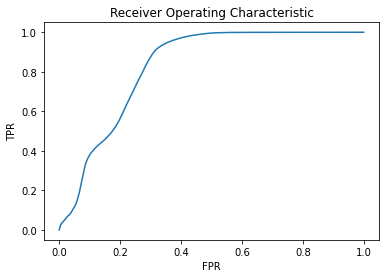

In [5]:
## Shift explanation and adaptation
utils.set_random_seed()
ohd_bgt = 10000
exp_result = sh.explainer(X_tre, label_num = ohd_bgt) # , auto_cali_thres=True
sh.adapter(model)

## Test the performance after OWAD adaptation
print('After OWAD Adaptation @2011:')
y_pred, y_prob = AE.test(sh.model, thres, X_1)
utils.multi_metrics(y_prob, y_1, thres*1.5)

**(As we can see that, OWAD Adaptation improves the performance of AD models from 0.80 to 0.82 with only 10k labels, which is 20% of validation set and 2.5% of testing set)**

## What about using retraining?
A common practice to tackle concept drift is to retrain the model with BOTH OLD and NEW samples. Here we'll show whether retraining works in this example.

epoch:0/10 |Loss: 0.013597141019999981
epoch:1/10 |Loss: 0.01309702917933464
epoch:2/10 |Loss: 0.012689960189163685
epoch:3/10 |Loss: 0.012229361571371555
epoch:4/10 |Loss: 0.01170630007982254
epoch:5/10 |Loss: 0.011155029758810997
epoch:6/10 |Loss: 0.01038495171815157
epoch:7/10 |Loss: 0.009331566281616688
epoch:8/10 |Loss: 0.00819298904389143
epoch:9/10 |Loss: 0.007417064160108566
max AD score 0.14777082
thres: 0.11793978
After Retraining:
roc_auc: 0.7896543349807552


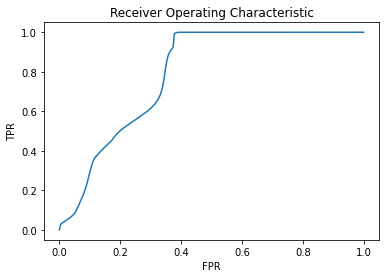

In [7]:
## retraining with all old samples and `ohd_bgt` new samples 
utils.set_random_seed()
X_retrain = np.concatenate((X_0[:train_num],X_1[:ohd_bgt]))
retrain_model, retrain_thres = AE.train(X_retrain, X_retrain.shape[-1])

## test the performance of retraining model
print('After Retraining:')
y_pred, y_prob = AE.test(retrain_model, retrain_thres, X_1)
utils.multi_metrics(y_prob, y_1, retrain_thres*1.5) 

**(As we can see that, Retraining actually has a negtive effect. Please refer to our paper for more analysis)**